## Impressions and Reviews  
- lasagne(theano) : neuralnetwork, layers api 지원, lightweight nn framework

In [4]:
%matplotlib inline

# Digit Recognizer in Python using Convolutional Neural Nets
by [Koba Khitalishvili](http://www.kobakhit.com/)
## Introduction
I used Mathematica and a standard Neural Network model to get ~0.98 accuracy score after 40 minutes of computing. Starting with a brief benchmark Python code [found in the forums](https://www.kaggle.com/c/digit-recognizer/forums/t/2299/getting-started-python-sample-code-random-forest) one can jump into solving the Digit Recognizer
problem right away. Below code that uses Random Forest algorithm to classify images as digits will give you 
around 0.96 accuracy score in less than a minute which is great. However, this score will put you lower than the 200th place. 
According to [MNIST web page](http://yann.lecun.com/exdb/mnist/), convolutional neural networks algorithm yields good results.
I will try a simple neural network algorithm out in Python, expand it into a convolutional neural network and see if I can break into the top 100.

In [7]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import pandas as pd

# create the training & test sets, skipping the header row with [1:]
dataset = pd.read_csv("/content/train.csv")
target = dataset.iloc[:,0].values.ravel() # (n,)
train = dataset.iloc[:,1:].values # (n, w*h*c)
test = pd.read_csv("/content/test.csv").values

# create and train the random forest
# multi-core CPUs can use: rf = RandomForestClassifier(n_estimators=100, n_jobs=2)
rf = RandomForestClassifier(n_estimators=100)
rf.fit(train, target)
pred = rf.predict(test)

np.savetxt('submission_rand_forest.csv', np.c_[range(1,len(test)+1),pred], delimiter=',', header = 'ImageId,Label', comments = '', fmt='%d')

## Table of contents
1. Data Preprocessing
2. Train, Predict and Save
3. Conclusion

## Data Preprocessing
First, lets prepare the data. The `train.csv` has 42k rows. The first column is the digit labels. The rest 784 columns
are pixel color values that go from 0 to 255. After loading in the csv files in code section above, I saved the digit labels in the `target` variable and rows of pixel color values  in the `train` variable. 
The `test.csv` contains 28k rows of just the pixel color values which we need to classify as digits. Here is the preview of the complete MNIST dataset.

In [13]:
dataset.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


I convert each data variable from a python list into a numpy array. For the `target` array I specify the integer data type.
The train set has 42k rows and 784 columns, so its shape is `(42k,784)`. Each row is a 28 by 28 pixel
picture. I will reshape the train set to have `(42k,1)` shape, i.e. each row will contain a 28 by 28 matrix of pixel color values. Same for the test set.

In [9]:
# convert to array, specify data type, and reshape
target = target.astype(np.uint8)

# 일단 channel first shape 
train = np.array(train).reshape((-1, 1, 28, 28)).astype(np.uint8)
test = np.array(test).reshape((-1, 1, 28, 28)).astype(np.uint8)

Now, we can actually plot those pixel color values and see what a sample picture of a digit looks like. Below is the picture of a digit in the 1729th row:

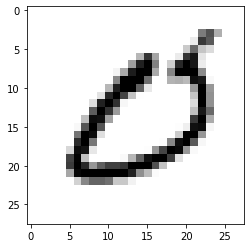

In [10]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

plt.imshow(train[1729][0], cmap=cm.binary) # draw the picture

## Train, Predict and Save
Below is a simple NN set up. Supposedly, it should give >0.9 accuracy score. I had trouble with figuring out
the training part in that the accuracy I was getting would not change during the training process. All I had to 
do was to decrease the learning rate from 0.01 to 0.0001, nota bene.

In [15]:
!pip install -r https://raw.githubusercontent.com/Lasagne/Lasagne/v0.1/requirements.txt
!pip install Lasagne==0.1

     |████████████████████████████████| 133kB 9.0MB/s 
  Created wheel for Lasagne: filename=Lasagne-0.1-cp36-none-any.whl size=79275 sha256=7c7ce4f220c71d70904bc8f2ea1b78328b59c99c38e3c3ba1bbc31413d4e7279
  Stored in directory: /root/.cache/pip/wheels/a5/8e/31/b4cae7e5507f8582e77d7f5cf2815be8820ccacfa0519ca60c
Successfully built Lasagne


In [17]:
!pip install theano

In [ ]:
# lasagne : theano based light neural network
import lasagne
from lasagne import layers
from lasagne.updates import nesterov_momentum
from nolearn.lasagne import NeuralNet
from nolearn.lasagne import visualize

net1 = NeuralNet(
        layers=[('input', layers.InputLayer),
                ('hidden', layers.DenseLayer),
                ('output', layers.DenseLayer),
                ],
        # layer parameters:
        input_shape=(None,1,28,28), # batch size 포함한 shape
        hidden_num_units=1000, # number of units in 'hidden' layer
        output_nonlinearity=lasagne.nonlinearities.softmax,
        output_num_units=10,  # 10 target values for the digits 0, 1, 2, ..., 9

        # optimization method:
        update = nesterov_momentum,
        update_learning_rate = 0.0001,
        update_momentum = 0.9,

        max_epochs=15,
        verbose=1,
        )

Now, lets train the model. 

In [ ]:
# Train the network
net1.fit(train, target)

You can see the output associated with the training process. Right off the bat this set up gives us ~0.95 accuracy
score in just 15 epochs which completes in less 3 minuts. Unfortunately, one layer neural network does not improve 
beyond 0.96 accuracy score ragardless of how many neurons in a layer is specified (1000 in case above).

I will try out the convolutional neural network. To set up the CNN I added two convolutional layers and one pooling layer. 
I would add another pooling layer and a dropout layer, but training such a model would last for over 20 minutes and kaggle notebook is only allowed to run for 1200 seconds (20 minutes). 
As a result, below is the CNN model I will use for demonstration.

In [ ]:
def CNN(n_epochs):
    net1 = NeuralNet(
        layers=[
        ('input', layers.InputLayer),
        ('conv1', layers.Conv2DLayer),      #Convolutional layer.  Params defined below
        ('pool1', layers.MaxPool2DLayer),   # Like downsampling, for execution speed
        ('conv2', layers.Conv2DLayer),
        ('hidden3', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],

    input_shape=(None, 1, 28, 28),
    conv1_num_filters=7, 
    conv1_filter_size=(3, 3), 
    conv1_nonlinearity=lasagne.nonlinearities.rectify, # relu
        
    pool1_pool_size=(2, 2),
        
    conv2_num_filters = 12, 
    conv2_filter_size = (2, 2),    
    conv2_nonlinearity = lasagne.nonlinearities.rectify,
        
    hidden3_num_units = 1000,
    output_num_units = 10, 
    output_nonlinearity = lasagne.nonlinearities.softmax,

    update_learning_rate = 0.0001,
    update_momentum = 0.9,

    max_epochs = n_epochs,
    verbose=1,
    )
    return net1

cnn = CNN(15).fit(train,target) # train the CNN model for 15 epochs


Looks like this CNN model produces a slightly better result than a simple NN model for the same number of epochs and neurons in the hidden layer. 
The CNN model was more time consuming though. If you think that it is not worth it to use the CNN model over the NN you are wrong.
NN model like any other has an upper bound on the best accuracy score it can produce. After 20 epochs 
NN model does not improve beyond ~0.97 whereas a CNN model gets closer to one. I was able to break into
top 100 and get the 94th place by using two convolutional layers and two pooling layers which gave me 0.98614 accuracy
in about 5 hours. I will provide the code in the post scriptum section.

So there you go. You have a starting point for using neural nets for image classification. 
If you expand on the info here and reach a score greater than 0.99 please drop a comment.
Now, lets use it on the test set and save the results.


In [ ]:
# use the NN model to classify test data
pred = cnn.predict(test)

# save results
np.savetxt('submission_cnn.csv', np.c_[range(1,len(test)+1),pred], delimiter=',', header = 'ImageId,Label', comments = '', fmt='%d')


## Conclusion
Python really stands out when it comes to solving data problems. Its quick, intuitive, well documented and has a big community.
However, its biggest drawback in my opinion is setting up the environment. My set up is [Jupyter Notebook](http://jupyter.org/) coupled 
with [Anaconda](https://www.continuum.io/downloads). Both are great tools, howeverm I ended up spending 
couple hours taking care of the dependencies theano and lasagne and the Windows environment variables. In contrast to Mathematica which 
has superb report generating options, setting up Python environment can be and was for me a tiring experience. Nevertheless, it pays off because 
Python framework is well developed for solving data problems. For instance, Mathematica does not even have a CNN
implementation available as of 11/4/2015 and everything is done under the hood whereas in a Python framework one 
can find almost any algorithm imaginable.

Among Python, R and Julia I beleive Python and R are most competitive data science technologies with Julia being 
in the process of maturing. Choosing Python over R and vica versa really has to do with either individual preference or
the suitability of the technology for the problem at hand. Python is more efficient than R. But Julia is more 
efficient than both Python and R.


### Resources Used:
[Convolutional Neural Networks (LeNet)](http://deeplearning.net/tutorial/lenet.html)

[CS231n Convolutional Neural Networks for Visual Recognition](http://cs231n.github.io/convolutional-networks/)

[Tutorial: Training convolutional neural networks with nolearn](http://nbviewer.ipython.org/github/dnouri/nolearn/blob/master/docs/notebooks/CNN_tutorial.ipynb)

[Using convolutional neural nets to detect facial keypoints tutorial](http://danielnouri.org/notes/2014/12/17/using-convolutional-neural-nets-to-detect-facial-keypoints-tutorial/)

[Deep learning – Convolutional neural networks and feature extraction with Python](http://blog.christianperone.com/2015/08/convolutional-neural-networks-and-feature-extraction-with-python/)